#3.1 Assignment


#Kg= gas conductance

#spherical distribution A(x)= 4pix^2

#displaystyle: gives bigger integral size

#\dfrac: this is for a display-style fraction

#\int: command for an integral symbol.



equ (3.7)Kg: $\dfrac{D_g} {\displaystyle\int_{x_1}^{x_2} {\dfrac{\mathrm{d}x}{A(x)}}} $

Kg: $ \dfrac{D_g}{\displaystyle\int_{x_1}^{x_2} \dfrac{\mathrm{d}x}{4 \pi x^2}} $

Kg: $ \dfrac{D_g}{\dfrac{1}{4\pi}\displaystyle\int_{x_1}^{x_2} \dfrac{\mathrm{d}x}{x^2}} $

Kg: $\dfrac{D_g}{\dfrac{1}{4\pi} * -(x^{-2}+1)}$

Kg: $ \dfrac{D_g} {\dfrac{1}{4\pi} * (\dfrac{x_2}{x_1*x_2} - \dfrac{x_1}{x_1*x_2})} $


 (Equation 3.10) Kg: $\dfrac{4 * \pi * D_g * x_1 *x_2}{x_2-x_1} $



equ (3.7) Kg: $\dfrac{D_g}{\displaystyle\int_{x_1}^{x_2} \dfrac{\mathrm{d}x}{A(x)}} $

Kg: $ \dfrac{D_g}{ \displaystyle\int_{x_1}^{x_2} \dfrac{\mathrm{d}x}{2 \pi  x}} $

Kg: $ \dfrac{D_g}{\dfrac{1}{2\pi}\displaystyle\int_{x_1}^{x_2} \dfrac{\mathrm{d}x}{x}} $

Kg: $ \dfrac{D_g}{\dfrac{1}{2\pi}*(\ln{x_2}-\ln{x_1})}  $

(Equation 3.11) Kg: $ \dfrac{2*\pi*D_g}{\ln{(x_2/x_1)}} $



node   depth [m]   Po2  Pco2
  0      0.00      0.210       0.000
  1      0.00      0.210       0.000
  2      0.03      0.204       0.006
  3      0.05      0.199       0.011
  4      0.08      0.195       0.015
  5      0.10      0.191       0.019
  6      0.12      0.187       0.023
  7      0.15      0.184       0.026
  8      0.17      0.181       0.029
  9      0.20      0.179       0.031
 10      0.22      0.177       0.033
 11      0.25      0.175       0.035
 12      0.27      0.173       0.037
 13      0.30      0.172       0.038
 14      0.33      0.171       0.039
 15      0.35      0.170       0.040
 16      0.38      0.169       0.041
 17      0.40      0.169       0.041
 18      0.43      0.168       0.042
 19      0.45      0.168       0.042
 20      0.48      0.168       0.042
 21      0.50      0.000       0.210
gas-filled porosity
0.25


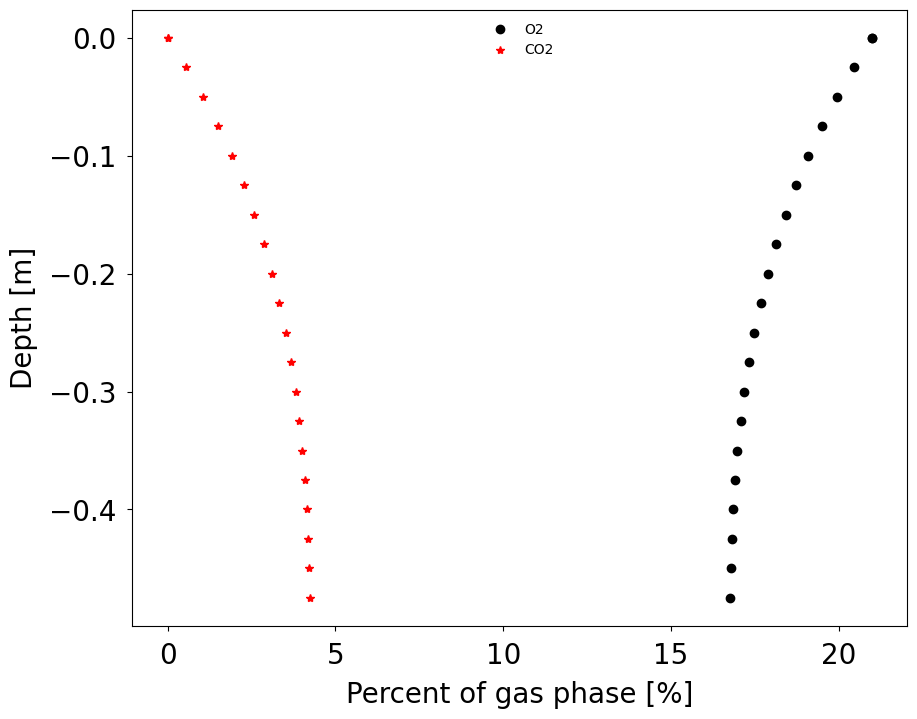

In [15]:
#3.2
#PSP_gasDiffusion
from math import exp
from PSP_ThomasAlgorithm import ThomasBoundaryCondition
import PSP_grid as grid
import matplotlib.pyplot as plt
import numpy as np

def gasSolver(boundaryLayerCond, boundaryOxygenConc, dg, 
                                respRate, totalDepth, n):
    a  = np.zeros(n+2, float)  
    b  = np.zeros(n+2, float)  
    c  = np.zeros(n+2, float)  
    d  = np.zeros(n+2, float) 
    g  = np.zeros(n+2, float) 
    u  = np.zeros(n+2, float)  
    co = np.zeros(n+2, float)  
    
    g[0] = boundaryLayerCond
    co[0] = boundaryOxygenConc
    # vector depth [m]
    z = grid.linear(n, totalDepth)
    
    # initialize matrix
    for i in range(1, n+1):
        u[i] = respRate * exp(-z[i] / 0.3) * (z[i + 1] - z[i - 1]) / 2.0
        if i < n:
            g[i] = dg / (z[i + 1] - z[i])
        else:
            g[i] = 0 #no flux at the bottom so g(i)=0
        a[i + 1] = -g[i]
        b[i] = g[i - 1] + g[i]
        c[i] = -g[i]
        d[i] = u[i]

    d[1] = d[1] + g[0] * co[0]
    
    ThomasBoundaryCondition(a, b, c, d, co, 1, n)
    
    return(z, co)


def main():
    R = 8.3143                     
    n = 20                        
    totalDepth = 0.5               
    bulkDensity = 1150.         #change from  1200 to 1150  
    particleDensity = 2650.         
    waterContent = 0.2               
    respRate = -0.001               
    oxygenDiff = 1.77e-5  #this is the value for oxygen         
    temperature = 25.             
    atmPressure = 101.3           
    boundaryLayerCond = 0.01     
    
    # O2 concentration in air [g/m^3]
    #.21 is partial pressure of oxygen
    #equation 3.15
    boundaryOxygenConc = (0.21 * atmPressure * 1000. * 32. / 
                          (R * (temperature + 273.15))) 
    porosity = 1. - bulkDensity / particleDensity
    gasPorosity = porosity - waterContent
    
    #  binary diffusion coefficient [m2/s]
    #101.3 written here is standard atm pressure
    binaryDiffCoeff = (oxygenDiff * (101.3 / atmPressure) 
                * ((temperature + 273.15) / 273.15)**1.75)
    
    bg = 0.9           
    mg = 2.3           
    dg = binaryDiffCoeff * bg * gasPorosity**mg
    
    z, co = gasSolver(boundaryLayerCond, boundaryOxygenConc, 
                      dg, respRate, totalDepth, n)
    
    po = co * R * (temperature + 273.15) / (atmPressure * 1000. * 32.) # partial pressure of O2
                           
    pco2 = 0.21 - po #partial pressure of CO2 assuming recipirocal relationship
      
    print ("node   depth [m]   Po2  Pco2")
    for i in range(n + 2):
        print ("%3d    %6.2f      %.3f       %.3f" %(i, z[i], po[i], pco2[i]))

    print ("gas-filled porosity")
    print("%.2f" %(gasPorosity))
    
    # plot results
    fig = plt.figure(figsize=(10,8))
    for i in range(n+1):
        plt.plot(100*po[i], -z[i], 'ko', 100*pco2[i], -z[i], 'r*')
    plt.legend(['O2', 'CO2'], loc="upper center", frameon = False)  
    plt.xlabel('Percent of gas phase [%]',fontsize=20,labelpad=8)
    plt.ylabel('Depth [m]',fontsize=20,labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
    plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
    plt.show()
main()


when bulk density increased from 1200 t0 1450 gas porosity decreased from 0.35 to  0.25, O2 concentration is greater than 15% and CO2 concentration is less than 5%

node   depth [m]   Po2  Pco2
  0      0.00      0.210       0.000
  1      0.00      0.210       0.000
  2      0.03      0.204       0.006
  3      0.05      0.199       0.011
  4      0.08      0.194       0.016
  5      0.10      0.190       0.020
  6      0.12      0.186       0.024
  7      0.15      0.183       0.027
  8      0.17      0.180       0.030
  9      0.20      0.177       0.033
 10      0.22      0.175       0.035
 11      0.25      0.173       0.037
 12      0.27      0.171       0.039
 13      0.30      0.170       0.040
 14      0.33      0.169       0.041
 15      0.35      0.168       0.042
 16      0.38      0.167       0.043
 17      0.40      0.166       0.044
 18      0.43      0.166       0.044
 19      0.45      0.166       0.044
 20      0.48      0.165       0.045
 21      0.50      0.000       0.210
gas-filled porosity
0.25


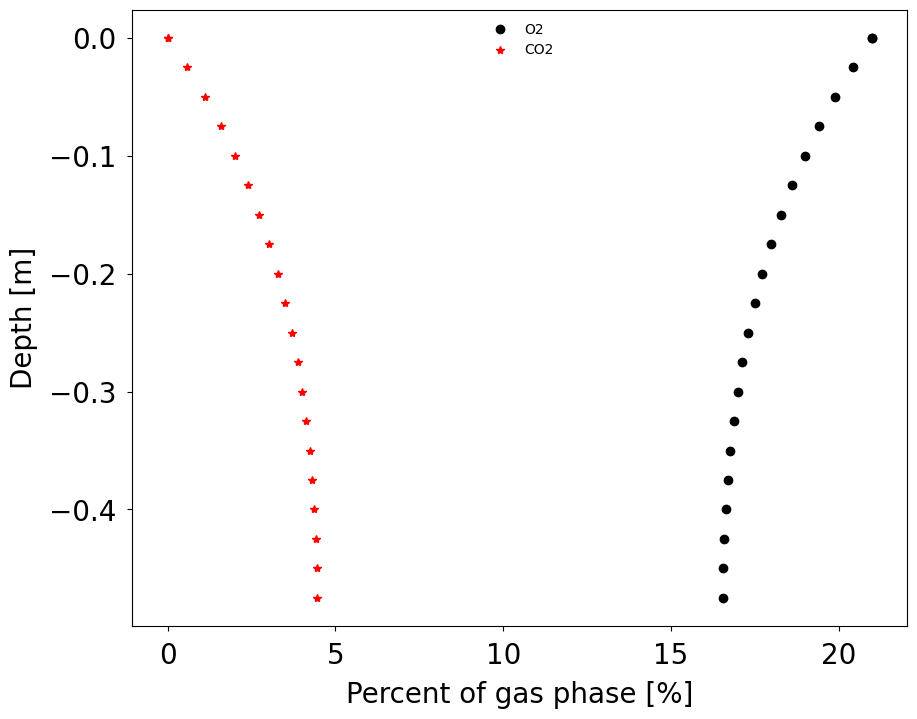

In [18]:
#3.2
#PSP_gasDiffusion
from math import exp
from PSP_ThomasAlgorithm import ThomasBoundaryCondition
import PSP_grid as grid
import matplotlib.pyplot as plt
import numpy as np

def gasSolver(boundaryLayerCond, boundaryOxygenConc, dg, 
                                respRate, totalDepth, n):
    a  = np.zeros(n+2, float)  
    b  = np.zeros(n+2, float)  
    c  = np.zeros(n+2, float)  
    d  = np.zeros(n+2, float) 
    g  = np.zeros(n+2, float) 
    u  = np.zeros(n+2, float)  
    co = np.zeros(n+2, float)  
    
    g[0] = boundaryLayerCond
    co[0] = boundaryOxygenConc
    # vector depth [m]
    z = grid.linear(n, totalDepth)
    
    # initialize matrix
    for i in range(1, n+1):
        u[i] = respRate * exp(-z[i] / 0.3) * (z[i + 1] - z[i - 1]) / 2.0
        if i < n:
            g[i] = dg / (z[i + 1] - z[i])
        else:
            g[i] = 0 #no flux at the bottom so g(i)=0
        a[i + 1] = -g[i]
        b[i] = g[i - 1] + g[i]
        c[i] = -g[i]
        d[i] = u[i]

    d[1] = d[1] + g[0] * co[0]
    
    ThomasBoundaryCondition(a, b, c, d, co, 1, n)
    
    return(z, co)


def main():
    R = 8.3143                     
    n = 20                        
    totalDepth = 0.5               
    bulkDensity = 1200.          
    particleDensity = 2650.         
    waterContent = 0.3     #changed from 0.2 to  0.3             
    respRate = -0.001               
    oxygenDiff = 1.77e-5  #this is the value for oxygen         
    temperature = 25.             
    atmPressure = 101.3           
    boundaryLayerCond = 0.01     
    
    # O2 concentration in air [g/m^3]
    #.21 is partial pressure of oxygen
    #equation 3.15
    boundaryOxygenConc = (0.21 * atmPressure * 1000. * 32. / 
                          (R * (temperature + 273.15))) 
    porosity = 1. - bulkDensity / particleDensity
    gasPorosity = porosity - waterContent
    
    #  binary diffusion coefficient [m2/s]
    #101.3 written here is standard atm pressure
    binaryDiffCoeff = (oxygenDiff * (101.3 / atmPressure) 
                * ((temperature + 273.15) / 273.15)**1.75)
    
    bg = 0.9           
    mg = 2.3           
    dg = binaryDiffCoeff * bg * gasPorosity**mg
    
    z, co = gasSolver(boundaryLayerCond, boundaryOxygenConc, 
                      dg, respRate, totalDepth, n)
    
    po = co * R * (temperature + 273.15) / (atmPressure * 1000. * 32.) # partial pressure of O2
                           
    pco2 = 0.21 - po #partial pressure of CO2 assuming recipirocal relationship
      
    print ("node   depth [m]   Po2  Pco2")
    for i in range(n + 2):
        print ("%3d    %6.2f      %.3f       %.3f" %(i, z[i], po[i], pco2[i]))

    print ("gas-filled porosity")
    print("%.2f" %(gasPorosity))
    
    # plot results
    fig = plt.figure(figsize=(10,8))
    for i in range(n+1):
        plt.plot(100*po[i], -z[i], 'ko', 100*pco2[i], -z[i], 'r*')
    plt.legend(['O2', 'CO2'], loc="upper center", frameon = False)  
    plt.xlabel('Percent of gas phase [%]',fontsize=20,labelpad=8)
    plt.ylabel('Depth [m]',fontsize=20,labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
    plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
    plt.show()
main()

when water content was reduced increased from 0.2 to 0.31 the CO2 concentration was equal to 5% below -.4 m, so I changed to 0.3 and CO2 is less than 5%. While the gas porosity is 0.25 

node   depth [m]   Po2  Pco2
  0      0.00      0.210       0.000
  1      0.00      0.210       0.000
  2      0.03      0.207       0.003
  3      0.05      0.205       0.005
  4      0.08      0.203       0.007
  5      0.10      0.201       0.009
  6      0.12      0.199       0.011
  7      0.15      0.197       0.013
  8      0.17      0.196       0.014
  9      0.20      0.195       0.015
 10      0.22      0.194       0.016
 11      0.25      0.193       0.017
 12      0.27      0.192       0.018
 13      0.30      0.191       0.019
 14      0.33      0.191       0.019
 15      0.35      0.190       0.020
 16      0.38      0.190       0.020
 17      0.40      0.190       0.020
 18      0.43      0.190       0.020
 19      0.45      0.189       0.021
 20      0.48      0.189       0.021
 21      0.50      0.000       0.210
gas-filled porosity
0.35


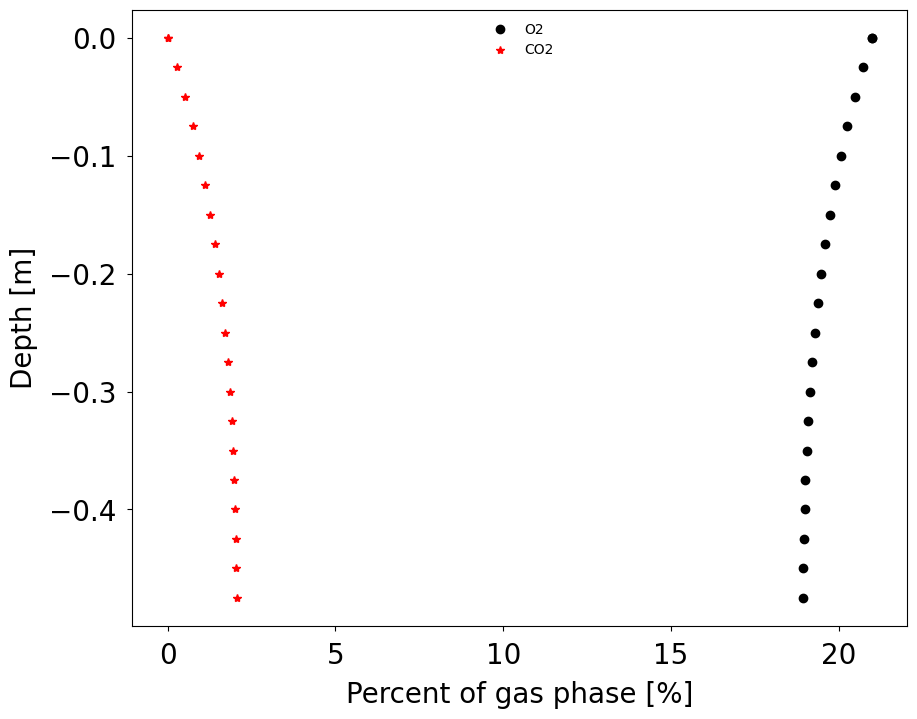

In [35]:
#3.2
#PSP_gasDiffusion
from math import exp
from PSP_ThomasAlgorithm import ThomasBoundaryCondition
import PSP_grid as grid
import matplotlib.pyplot as plt
import numpy as np

def gasSolver(boundaryLayerCond, boundaryOxygenConc, dg, 
                                respRate, totalDepth, n):
    a  = np.zeros(n+2, float)  
    b  = np.zeros(n+2, float)  
    c  = np.zeros(n+2, float)  
    d  = np.zeros(n+2, float) 
    g  = np.zeros(n+2, float) 
    u  = np.zeros(n+2, float)  
    co = np.zeros(n+2, float)  
    
    g[0] = boundaryLayerCond
    co[0] = boundaryOxygenConc
    # vector depth [m]
    z = grid.linear(n, totalDepth)
    
    # initialize matrix
    for i in range(1, n+1):
        u[i] = respRate * exp(-z[i] / 0.3) * (z[i + 1] - z[i - 1]) / 2.0
        if i < n:
            g[i] = dg / (z[i + 1] - z[i])
        else:
            g[i] = 0 #no flux at the bottom so g(i)=0
        a[i + 1] = -g[i]
        b[i] = g[i - 1] + g[i]
        c[i] = -g[i]
        d[i] = u[i]

    d[1] = d[1] + g[0] * co[0]
    
    ThomasBoundaryCondition(a, b, c, d, co, 1, n)
    
    return(z, co)


def main():
    R = 8.3143                     
    n = 20                        
    totalDepth = 0.5               
    bulkDensity = 1200.          
    particleDensity = 2650.         
    waterContent = 0.2                  
    respRate = -0.001               
    oxygenDiff = 1.77e-5  #this is the value for oxygen         
    temperature = 25.             
    atmPressure = 101.3           
    boundaryLayerCond = 0.001    #changed from 0.01 to 0.001
    
    # O2 concentration in air [g/m^3]
    #.21 is partial pressure of oxygen
    #equation 3.15
    boundaryOxygenConc = (0.21 * atmPressure * 1000. * 32. / 
                          (R * (temperature + 273.15))) 
    porosity = 1. - bulkDensity / particleDensity
    gasPorosity = porosity - waterContent
    
    #  binary diffusion coefficient [m2/s]
    #101.3 written here is standard atm pressure
    binaryDiffCoeff = (oxygenDiff * (101.3 / atmPressure) 
                * ((temperature + 273.15) / 273.15)**1.75)
    
    bg = 0.9           
    mg = 2.3           
    dg = binaryDiffCoeff * bg * gasPorosity**mg
    
    z, co = gasSolver(boundaryLayerCond, boundaryOxygenConc, 
                      dg, respRate, totalDepth, n)
    
    po = co * R * (temperature + 273.15) / (atmPressure * 1000. * 32.) # partial pressure of O2
                           
    pco2 = 0.21 - po #partial pressure of CO2 assuming recipirocal relationship
      
    print ("node   depth [m]   Po2  Pco2")
    for i in range(n + 2):
        print ("%3d    %6.2f      %.3f       %.3f" %(i, z[i], po[i], pco2[i]))

    print ("gas-filled porosity")
    print("%.2f" %(gasPorosity))
    
    # plot results
    fig = plt.figure(figsize=(10,8))
    for i in range(n+1):
        plt.plot(100*po[i], -z[i], 'ko', 100*pco2[i], -z[i], 'r*')
    plt.legend(['O2', 'CO2'], loc="upper center", frameon = False)  
    plt.xlabel('Percent of gas phase [%]',fontsize=20,labelpad=8)
    plt.ylabel('Depth [m]',fontsize=20,labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
    plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
    plt.show()
main()

when the boundary layer conductance was change ( decreased from 0.01 to 0.0001, and increased from 0.01 to 100000) no much chnage in gas porosity and CO2 and O2 concentration was seen. So, it was change to 0.001 only.

node   depth [m]   Po2  Pco2
  0      0.00      0.210       0.000
  1      0.00      0.210       0.000
  2      0.03      0.205       0.005
  3      0.05      0.200       0.010
  4      0.08      0.196       0.014
  5      0.10      0.193       0.017
  6      0.12      0.190       0.020
  7      0.15      0.187       0.023
  8      0.17      0.184       0.026
  9      0.20      0.182       0.028
 10      0.22      0.180       0.030
 11      0.25      0.179       0.031
 12      0.27      0.177       0.033
 13      0.30      0.176       0.034
 14      0.33      0.175       0.035
 15      0.35      0.174       0.036
 16      0.38      0.173       0.037
 17      0.40      0.173       0.037
 18      0.43      0.173       0.037
 19      0.45      0.172       0.038
 20      0.48      0.172       0.038
 21      0.50      0.000       0.210
gas-filled porosity
0.27


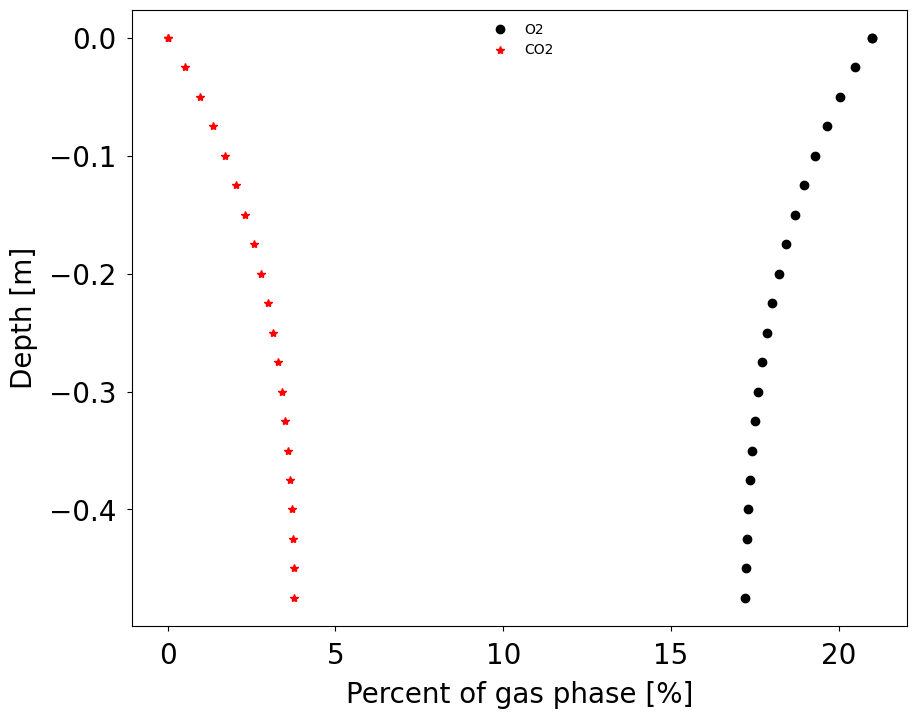

In [38]:
#3.3
#PSP_gasDiffusion
from math import exp
from PSP_ThomasAlgorithm import ThomasBoundaryCondition
import PSP_grid as grid
import matplotlib.pyplot as plt
import numpy as np

def gasSolver(boundaryLayerCond, boundaryOxygenConc, dg, 
                                respRate, totalDepth, n):
    a  = np.zeros(n+2, float)  
    b  = np.zeros(n+2, float)  
    c  = np.zeros(n+2, float)  
    d  = np.zeros(n+2, float) 
    g  = np.zeros(n+2, float) 
    u  = np.zeros(n+2, float)  
    co = np.zeros(n+2, float)  
    
    g[0] = boundaryLayerCond
    co[0] = boundaryOxygenConc
    # vector depth [m]
    z = grid.linear(n, totalDepth)
    
    # initialize matrix
    for i in range(1, n+1):
        u[i] = respRate * exp(-z[i] / 0.3) * (z[i + 1] - z[i - 1]) / 2.0
        if i < n:
            g[i] = dg / (z[i + 1] - z[i])
        else:
            g[i] = 0 #no flux at the bottom so g(i)=0
        a[i + 1] = -g[i]
        b[i] = g[i - 1] + g[i]
        c[i] = -g[i]
        d[i] = u[i]

    d[1] = d[1] + g[0] * co[0]
    
    ThomasBoundaryCondition(a, b, c, d, co, 1, n)
    
    return(z, co)


def main():
    R = 8.3143                     
    n = 20                        
    totalDepth = 0.5               
    bulkDensity = 1150.          
    particleDensity = 2650.         
    waterContent = 0.3                  
    respRate = -0.001               
    oxygenDiff = 1.77e-5  #this is the value for oxygen         
    temperature = 25.             
    atmPressure = 101.3           
    boundaryLayerCond = 0.001    #changed from 0.01 to 0.001
    
    # O2 concentration in air [g/m^3]
    #.21 is partial pressure of oxygen
    #equation 3.15
    boundaryOxygenConc = (0.21 * atmPressure * 1000. * 32. / 
                          (R * (temperature + 273.15))) 
    porosity = 1. - bulkDensity / particleDensity
    gasPorosity = porosity - waterContent
    
    #  binary diffusion coefficient [m2/s]
    #101.3 written here is standard atm pressure
    binaryDiffCoeff = (oxygenDiff * (101.3 / atmPressure) 
                * ((temperature + 273.15) / 273.15)**1.75)
    
    bg = 0.9           
    mg = 2.3           
    dg = binaryDiffCoeff * bg * gasPorosity**mg
    
    z, co = gasSolver(boundaryLayerCond, boundaryOxygenConc, 
                      dg, respRate, totalDepth, n)
    
    po = co * R * (temperature + 273.15) / (atmPressure * 1000. * 32.) # partial pressure of O2
                           
    pco2 = 0.21 - po #partial pressure of CO2 assuming recipirocal relationship
      
    print ("node   depth [m]   Po2  Pco2")
    for i in range(n + 2):
        print ("%3d    %6.2f      %.3f       %.3f" %(i, z[i], po[i], pco2[i]))

    print ("gas-filled porosity")
    print("%.2f" %(gasPorosity))
    
    # plot results
    fig = plt.figure(figsize=(10,8))
    for i in range(n+1):
        plt.plot(100*po[i], -z[i], 'ko', 100*pco2[i], -z[i], 'r*')
    plt.legend(['O2', 'CO2'], loc="upper center", frameon = False)  
    plt.xlabel('Percent of gas phase [%]',fontsize=20,labelpad=8)
    plt.ylabel('Depth [m]',fontsize=20,labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
    plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
    plt.show()
main()

node   depth [m]   Po2  Pco2
  0      0.00      0.210       0.000
  1      0.00      0.210       0.000
  2      0.03      -0.055       0.265
  3      0.05      -0.292       0.502
  4      0.08      -0.506       0.716
  5      0.10      -0.697       0.907
  6      0.12      -0.867       1.077
  7      0.15      -1.018       1.228
  8      0.17      -1.151       1.361
  9      0.20      -1.269       1.479
 10      0.22      -1.371       1.581
 11      0.25      -1.460       1.670
 12      0.27      -1.536       1.746
 13      0.30      -1.601       1.811
 14      0.33      -1.655       1.865
 15      0.35      -1.700       1.910
 16      0.38      -1.735       1.945
 17      0.40      -1.762       1.972
 18      0.43      -1.781       1.991
 19      0.45      -1.794       2.004
 20      0.48      -1.800       2.010
 21      0.50      0.000       0.210
gas-filled porosity
0.05


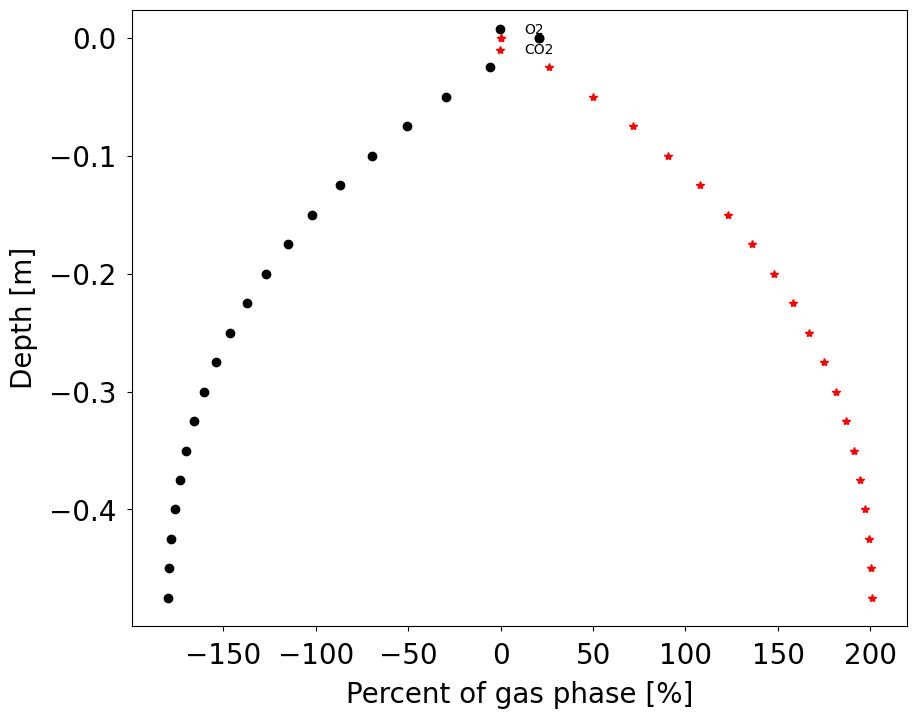

In [49]:
#PSP_gasDiffusion
from math import exp
from PSP_ThomasAlgorithm import ThomasBoundaryCondition
import PSP_grid as grid
import matplotlib.pyplot as plt
import numpy as np

def gasSolver(boundaryLayerCond, boundaryOxygenConc, dg, 
                                respRate, totalDepth, n):
    a  = np.zeros(n+2, float)  
    b  = np.zeros(n+2, float)  
    c  = np.zeros(n+2, float)  
    d  = np.zeros(n+2, float) 
    g  = np.zeros(n+2, float) 
    u  = np.zeros(n+2, float)  
    co = np.zeros(n+2, float)  
    
    g[0] = boundaryLayerCond
    co[0] = boundaryOxygenConc
    # vector depth [m]
    z = grid.linear(n, totalDepth)
    
    # initialize matrix
    for i in range(1, n+1):
        u[i] = respRate * exp(-z[i] / 0.3) * (z[i + 1] - z[i - 1]) / 2.0
        if i < n:
            g[i] = dg / (z[i + 1] - z[i])
        else:
            g[i] = 0 #no flux at the bottom so g(i)=0
        a[i + 1] = -g[i]
        b[i] = g[i - 1] + g[i]
        c[i] = -g[i]
        d[i] = u[i]

    d[1] = d[1] + g[0] * co[0]
    
    ThomasBoundaryCondition(a, b, c, d, co, 1, n)
    
    return(z, co)


def main():
    R = 8.3143                     
    n = 20                        
    totalDepth = 0.5               
    bulkDensity = 1200.          
    particleDensity = 2650.         
    waterContent = 0.5               
    respRate = -0.001               
    oxygenDiff = 1.77e-5  #this is the value for oxygen         
    temperature = 25.             
    atmPressure = 101.3           
    boundaryLayerCond = 0.001    #changed from 0.01 to 0.001
    
    # O2 concentration in air [g/m^3]
    #.21 is partial pressure of oxygen
    #equation 3.15
    boundaryOxygenConc = (0.21 * atmPressure * 1000. * 32. / 
                          (R * (temperature + 273.15))) 
    porosity = 1. - bulkDensity / particleDensity
    gasPorosity = porosity - waterContent
    
    #  binary diffusion coefficient [m2/s]
    #101.3 written here is standard atm pressure
    binaryDiffCoeff = (oxygenDiff * (101.3 / atmPressure) 
                * ((temperature + 273.15) / 273.15)**1.75)
    
    bg = 0.9           
    mg = 2.3           
    dg = binaryDiffCoeff * bg * gasPorosity**mg
    
    z, co = gasSolver(boundaryLayerCond, boundaryOxygenConc, 
                      dg, respRate, totalDepth, n)
    
    po = co * R * (temperature + 273.15) / (atmPressure * 1000. * 32.) # partial pressure of O2
                           
    pco2 = 0.21 - po #partial pressure of CO2 assuming recipirocal relationship
      
    print ("node   depth [m]   Po2  Pco2")
    for i in range(n + 2):
        print ("%3d    %6.2f      %.3f       %.3f" %(i, z[i], po[i], pco2[i]))

    print ("gas-filled porosity")
    print("%.2f" %(gasPorosity))
    
    # plot results
    fig = plt.figure(figsize=(10,8))
    for i in range(n+1):
        plt.plot(100*po[i], -z[i], 'ko', 100*pco2[i], -z[i], 'r*')
    plt.legend(['O2', 'CO2'], loc="upper center", frameon = False)  
    plt.xlabel('Percent of gas phase [%]',fontsize=20,labelpad=8)
    plt.ylabel('Depth [m]',fontsize=20,labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
    plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
    plt.show()
main()

With high bulk density (1450) and water content 0.3 the CO2 concentration start increasing rapidly with depth and the graph is intersect. But if water content is 0.2 and bulk density is 1450 it shows same graph as other.

In [ ]:
#code doesnot run if watercontent is more than 0.6 with bulk density 1200.